In [1]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# 如果需要使用google雲端硬碟才會使用

Mounted at /content/drive


In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

plm = "EleutherAI/pythia-160m-deduped"

bos = '<|endoftext|>'
eos = '<|END|>'
pad = '<|pad|>'
sep ='\n\n####\n\n'

special_tokens_dict = {'eos_token': eos, 'bos_token': bos, 'pad_token': pad, 'sep_token': sep}

tokenizer = AutoTokenizer.from_pretrained(plm, revision="step3000")
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.padding_side = 'left'

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

In [4]:
from datasets import load_dataset, Features, Value
dataset = load_dataset("csv", data_files=["訓練資料"], delimiter='\t',
                       features = Features({
                              'fid': Value('string'), 'idx': Value('int64'),
                              'content': Value('string'), 'label': Value('string')}),
                       column_names=['fid', 'idx', 'content', 'label'], keep_default_na=False)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
import torch
sub_datasets = torch.utils.data.random_split(dataset['train'], [欲分割檔案數量,總檔案數量-欲分割檔案數量])
print(len(sub_datasets[0]))
for i in range(4): print(sub_datasets[0][i])

164495
{'fid': '1346', 'idx': 932, 'content': 'The serosal surface is smooth.', 'label': 'PHI: NULL'}
{'fid': 'file68051', 'idx': 4571, 'content': 'The left fallopian tube and ovary are widely replaced by High grade Serous carcinoma showing no convincing response to adjuvant therapy.', 'label': 'PHI: NULL'}
{'fid': '1308', 'idx': 2535, 'content': 'Maximum extent of DCIS: 22mm', 'label': 'PHI: NULL'}
{'fid': 'file8839', 'idx': 645, 'content': 'The mass is multicystic and has a mostly smooth outer surface with some small nodular deposits.', 'label': 'PHI: NULL'}


In [6]:
PAD_IDX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
IGNORED_PAD_IDX = -100
PAD_IDX

50278

In [7]:
from torch.utils.data import DataLoader
import torch

train_data = list(sub_datasets[0])

def collate_batch(batch):
    texts = [f"{bos} {data['content']} {sep}"+ data['label'].replace('\\n','\n')+f" {eos}" for data in list(batch)] # 範例 prompt
    encoded_seq = tokenizer(texts, padding=True)

    indexed_tks = torch.tensor(encoded_seq['input_ids'])
    attention_mask = torch.tensor(encoded_seq['attention_mask'])
    encoded_label = torch.tensor(encoded_seq['input_ids'])
    encoded_label[encoded_label == tokenizer.pad_token_id] = IGNORED_PAD_IDX

    return indexed_tks, encoded_label, attention_mask

train_dataloader = DataLoader(train_data, batch_size=2, shuffle=False, collate_fn=collate_batch)
titer = iter(train_dataloader)
tks, labels, masks= next(titer)
print(tks.shape)
next(iter(titer))

torch.Size([2, 33])


(tensor([[50278, 50278, 50278, 50278, 50278, 50278, 50278, 50278, 50278, 50278,
          50278, 50278,     0, 32642,  6070,   273,  9087,  1830,    27,  3307,
           2188,   209, 50279,  6663,    42,    27,  5812,   209, 50277],
         [    0,   380,  2280,   310,  1554,  2576, 11224,   285,   556,   247,
           6571,  6032,  8346,  2553,   342,   690,  1355,  6913,   792, 22413,
             15,   209, 50279,  6663,    42,    27,  5812,   209, 50277]]),
 tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,     0, 32642,  6070,   273,  9087,  1830,    27,  3307,
           2188,   209, 50279,  6663,    42,    27,  5812,   209, 50277],
         [    0,   380,  2280,   310,  1554,  2576, 11224,   285,   556,   247,
           6571,  6032,  8346,  2553,   342,   690,  1355,  6913,   792, 22413,
             15,   209, 50279,  6663,    42,    27,  5812,   209, 50277]]),
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,

In [8]:
import random
BATCH_SIZE = 5 # 自行決定大小

class BatchSampler():
    def __init__(self, data, batch_size):
        self.pooled_indices = []
        self.data = data
        self.batch_size = batch_size
        self.len = len(list(data))
    def __iter__(self):
        self.pooled_indices = []
        indices = [(index, len(data["content"])) for index, data in enumerate(self.data)]
        random.shuffle(indices)
        for i in range(0, len(indices), BATCH_SIZE * 100):
            self.pooled_indices.extend(sorted(indices[i:i + BATCH_SIZE * 100], key=lambda x: x[1], reverse=True))
        self.pooled_indices = [x[0] for x in self.pooled_indices]

        for i in range(0, len(self.pooled_indices), BATCH_SIZE):
            yield self.pooled_indices[i:i + BATCH_SIZE]
    def __len__(self):
        return (self.len + self.batch_size - 1) // self.batch_size

bucket_train_dataloader = DataLoader(train_data, batch_sampler=BatchSampler(train_data, BATCH_SIZE),
                                     collate_fn=collate_batch, pin_memory=True)

In [9]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained(plm,
                                    bos_token_id=tokenizer.bos_token_id,
                                    eos_token_id=tokenizer.eos_token_id,
                                    pad_token_id=tokenizer.pad_token_id,
                                    sep_token_id=tokenizer.sep_token_id,
                                    output_hidden_states=False)

model = AutoModelForCausalLM.from_pretrained(plm,  revision="step3000", config=config)
model

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/375M [00:00<?, ?B/s]

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 768)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=768, out_features=3072, bias=True)
          (dense_4h_to_h): Linear(in_features=3072, out_features=768, bias=True)
          

In [ ]:
print(f"Number of tranable paremeters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Number of tranable paremeters: 162322944


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 768)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=768, out_features=3072, bias=True)
          (dense_4h_to_h): Linear(in_features=3072, out_features=768, bias=True)
          

In [11]:
import torch
from tqdm import tqdm, tqdm_notebook
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def sample_text(model, tokenizer, seed, n_words=20):
    model = model.to(device)
    model.eval()
    text = tokenizer.encode(seed)
    inputs, past_key_values = torch.tensor([text]), None
    with torch.no_grad():
        for _ in tqdm(range(n_words)):
            out = model(inputs.to(device), past_key_values=past_key_values)
            logits = out.logits
            past_key_values = out.past_key_values
            log_probs = F.softmax(logits[:, -1], dim=-1)
            inputs = torch.multinomial(log_probs, 1)
            text.append(inputs.item())
            if tokenizer.decode(inputs.item()) == eos:
                break


    return tokenizer.decode(text)

sample_text(model, tokenizer, seed=f"{bos} DR AADLAND ABRAHAM {sep}")

100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


'<|endoftext|> DR AADLAND ABRAHAM \n\n####\n\n its currency. Watch this customer compensation statement. Unlike a checking account with money is yield and discount lenders'

In [12]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

EPOCHS = 4 # 設定你的訓練次數
optimizer = AdamW(model.parameters(),lr=5e-5)

steps = len(bucket_train_dataloader)
total_steps = steps * EPOCHS
print(steps, total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=total_steps*0.1,
    num_training_steps=total_steps
)

model.resize_token_embeddings(len(tokenizer))
model.to(device)
print(f'Total numbers of steps: {total_steps}')
model


32899 131596
Total numbers of steps: 131596


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50280, 768)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=768, out_features=2304, bias=True)
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=768, out_features=3072, bias=True)
          (dense_4h_to_h): Linear(in_features=3072, out_features=768, bias=True)
          

In [14]:
from tqdm import tqdm,trange

global_step = 0
total_loss = 0
Train=[]
model.train()
for _ in trange(EPOCHS, desc="Epoch"):
    model.train()
    total_loss = 0

    predictions , true_labels = [], []

    for step, (seqs, labels, masks) in enumerate(bucket_train_dataloader):
        seqs = seqs.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
        model.zero_grad()
        outputs = model(seqs, labels=labels, attention_mask=masks)
        logits = outputs.logits
        loss = outputs.loss
        loss = loss.mean()
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
    avg_train_loss = total_loss / len(bucket_train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    Train.append(avg_train_loss)
    torch.save(model,'content/drive/save.pt')

Epoch:  25%|██▌       | 1/4 [45:25<2:16:15, 2725.24s/it]

Average train loss: 1.3435855903237122


Epoch:  50%|█████     | 2/4 [1:30:46<1:30:45, 2722.63s/it]

Average train loss: 1.0017957574841303


Epoch:  75%|███████▌  | 3/4 [2:16:14<45:25, 2725.37s/it]  

Average train loss: 0.802525232390193


Epoch: 100%|██████████| 4/4 [3:01:39<00:00, 2724.82s/it]

Average train loss: 0.6523054568642501


In [15]:
!pip install matplotlib

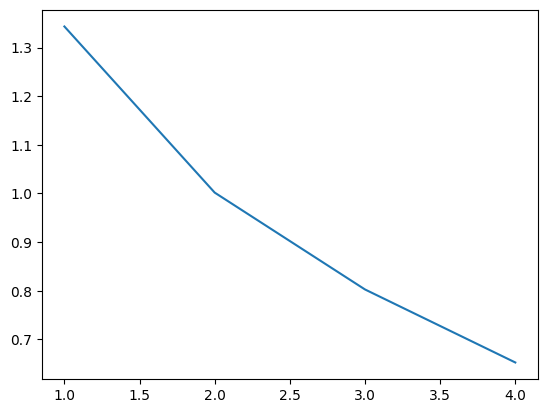

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(Train)+1), Train)

In [18]:
from datasets import load_dataset, Features, Value
valid_data = load_dataset("csv", data_files="opendid_test.tsv", delimiter='\t',
                          features = Features({
                              'fid': Value('string'), 'idx': Value('int64'),
                              'content': Value('string'), 'label': Value('string')}),
                              column_names=['fid', 'idx', 'content', 'label'])
valid_list= list(valid_data['train'])
valid_list

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

[{'fid': '1097', 'idx': 1, 'content': '433475.RDC', 'label': None},
 {'fid': '1097', 'idx': 12, 'content': 'Timmins, ELDEN', 'label': None},
 {'fid': '1097', 'idx': 27, 'content': '43J47561,43J47561', 'label': None},
 {'fid': '1097',
  'idx': 46,
  'content': 'Last edited : 7/9/2063  Page: 2',
  'label': None},
 {'fid': '1097', 'idx': 78, 'content': 'CLINICAL:', 'label': None},
 {'fid': '1097',
  'idx': 88,
  'content': 'Metastatic cancer ?colorectal primary.',
  'label': None},
 {'fid': '1097', 'idx': 128, 'content': 'MACROSCOPIC:', 'label': None},
 {'fid': '1097',
  'idx': 141,
  'content': 'Specimen labelled "Omentum secondary", consists of a piece of omentum 120 x 100 x 30mm.',
  'label': None},
 {'fid': '1097',
  'idx': 230,
  'content': 'On sectioning there are multiple fibrotic white ill-defined nodules identified.',
  'label': None},
 {'fid': '1097',
  'idx': 312,
  'content': 'Blocks: 1 to 5 - representative sections from the nodules.',
  'label': None},
 {'fid': '1097',
  'id

In [22]:
from tqdm import tqdm, tqdm_notebook

tokenizer.padding_side = 'left'
def sample_batch(model, tokenizer, input):
    """Generate text from a trained model."""
    model.eval()
    seeds = [f"{bos} {text['content']} {sep}" for text in input]
    texts = tokenizer(seeds, return_tensors = 'pt', padding=True).to(device)
    outputs = []
    #return
    with torch.cuda.amp.autocast():
        output_tokens = model.generate(**texts, max_new_tokens=400, pad_token_id = PAD_IDX,
                                        eos_token_id=tokenizer.convert_tokens_to_ids(eos))
        preds = tokenizer.batch_decode(output_tokens)
        for idx , pred in enumerate(preds):
            pred = pred[pred.index(sep)+len(sep):].replace(pad, "").replace(eos, "").strip()
            if pred == "PHI: NULL":
                continue
            phis = pred.split('\n')
            lidxs = {}
            for p in phis:
                tid = p.find(':')
                if tid > 0:
                    text = p[tid+1:].strip()
                    nv = text.find('=>')
                    normalizedV = None
                    if(nv>0):
                      normalizedV = text[nv+2:]
                      text=text[:nv]
                    lidx = 0
                    if text in lidxs:
                        lidx = lidxs[text]
                    lidx = input[idx]['content'].find(text, lidx)
                    eidx = lidx+len(text)
                    lidxs[text] = eidx
                    sidx=int(input[idx]['idx'])
                    if normalizedV is None:
                        outputs.append(f'{input[idx]["fid"]}\t{p[:tid]}\t{lidx+sidx}\t{eidx+sidx}\t{text}')
                    else:
                        outputs.append(f'{input[idx]["fid"]}\t{p[:tid]}\t{lidx+sidx}\t{eidx+sidx}\t{text}\t{normalizedV}')
    return outputs

f = open("欲存放檔案路徑/output.txt", "w",encoding="utf-8")
BATCH_SIZE = 32
for i in tqdm(range(0, len(valid_list), BATCH_SIZE)):
    with torch.no_grad():
        seeds = valid_list[i:i+BATCH_SIZE]
        outputs = sample_batch(model, tokenizer, input=seeds)
        for o in outputs:
            f.write(o)
            f.write('\n')
f.close()

100%|██████████| 2469/2469 [18:39<00:00,  2.21it/s]


In [ ]:
import os
import pandas as pd

os.chdir('檔案路徑')
a=['PATIENT','DOCTOR','USERNAME','ROOM','DEPARTMENT','HOSPITAL','ORGANIZATION','STREET',
   'CITY','STATE','ZIP','AGE','DATE','TIME','PHONE','DURATION','LOCATION-OTHER','SET',
    'MEDICALRECORD','FAX','EMAIL','URL','IPADDR','SSN','HEALTHPLAN','ACCOUNT','LICENSE','VECHICLE','DEVICE','BIOID',
   'IDNUM','OTHER']
df = pd.read_csv("output.txt",sep='\t',header=None,index_col=False,names=['file_name','label','start','end','context','多的'])
df_cleaned = df.dropna(subset=['context']).copy()
for index, row in df_cleaned.iterrows():
    drop_row = True
    for j in range(len(a)):
        if row['label'] == a[j]:
            drop_row = False
            break
    if drop_row:
        print(row)
        df_cleaned = df_cleaned.drop(index)
# 查找並刪除重複的行
duplicates = df_cleaned[df_cleaned.duplicated(subset=['file_name', 'label', 'context', 'end'], keep=False)]
df_cleaned = df_cleaned.drop_duplicates(subset=['file_name', 'label', 'context', 'end'], keep=False)
print("剩餘的 DataFrame:")
print(df_cleaned)
pd.set_option('display.max_rows',None)
print(df_cleaned)
df_cleaned.to_csv('answer.txt', index=False, header=False, sep='\t')